<a href="https://colab.research.google.com/github/achmadbadri/Aktivasi-LSTM/blob/main/HMSP_2020_exponential_Test_3_R2_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas as pd 
import pandas_datareader.data as web
import datetime
import numpy as np 
from matplotlib import style
from google.colab import files
# Visualize the training stock data:
import matplotlib.pyplot as plt
%matplotlib inline

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get the stock data using yahoo API:
style.use('ggplot')

# get 2014-2018 data to train our model
start = datetime.datetime(2014,1,1)
end = datetime.datetime(2019,12,31)
df = web.DataReader("HMSP.JK", 'yahoo', start, end) 

# get 2019 data to test our model on 
start = datetime.datetime(2019,11,7)
end = datetime.datetime(2020,12,31)
test_df = web.DataReader("HMSP.JK", 'yahoo', start, end) 
print(df.shape)
print(test_df.shape)

(1508, 6)
(278, 6)


In [3]:
# Create train set of adj close prices data:
train_data = df.loc[:,'Adj Close'].to_numpy()
print(train_data.shape) # 1258 


# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

(1508,)


In [4]:
'''Function to create a dataset to feed into an LSTM'''
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
    
    
# Create the data to train our model on:
time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))

print(X_train.shape)


# Visualizing our data with prints: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

(1472, 36, 1)
X_train:
[[1845.97399902]
 [1844.49633789]
 [1819.37072754]
 [1807.546875  ]
 [1795.72351074]
 [1789.81164551]
 [1803.11303711]
 [1817.89282227]
 [1891.7911377 ]
 [1891.7911377 ]
 [1891.7911377 ]
 [1890.31274414]
 [1902.13659668]
 [1906.57067871]
 [1920.61120605]
 [2002.63793945]
 [2001.16040039]
 [1952.38720703]
 [1949.43151855]
 [1981.9465332 ]
 [1965.68920898]
 [1977.51306152]
 [2011.5057373 ]
 [2061.75634766]
 [2098.70556641]
 [2098.70556641]
 [2098.70556641]
 [2045.49865723]
 [2061.75634766]
 [2046.97668457]
 [2046.97668457]
 [2039.58666992]
 [2036.63085938]
 [2036.63085938]
 [2030.71911621]
 [2030.71911621]]


y_train: [[2024.80737305]]



In [5]:
# Build the model 
model = keras.Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 64, return_sequences = False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1, activation= 'exponential'))
# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)

Epoch 1/20
103/103 [==============================] - 7s 48ms/step - loss: 0.1110 - val_loss: 0.0076
Epoch 2/20
103/103 [==============================] - 4s 39ms/step - loss: 0.0076 - val_loss: 0.0038
Epoch 3/20
103/103 [==============================] - 4s 37ms/step - loss: 0.0048 - val_loss: 0.0038
Epoch 4/20
103/103 [==============================] - 4s 39ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 5/20
103/103 [==============================] - 4s 39ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 6/20
103/103 [==============================] - 4s 38ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 7/20
103/103 [==============================] - 4s 39ms/step - loss: 0.0024 - val_loss: 0.0042
Epoch 8/20
103/103 [==============================] - 4s 38ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 9/20
103/103 [==============================] - 4s 39ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 10/20
103/103 [==============================] - 4s 38ms/step - loss: 0.0023 - val_lo

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 36, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 36, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


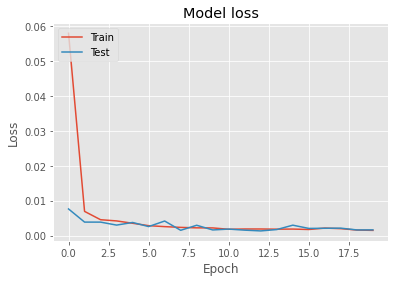

In [7]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [8]:
# Get the stock prices for 2019 to have our model make the predictions
test_data = test_df['Adj Close'].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
time_steps = 36
X_test, y_test = create_dataset(test_data, time_steps)

# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
true = y_test
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], 36, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
pred = predicted_y
predicted_y = scaler.inverse_transform(predicted_y)


In [9]:
# MSE
difference_array = np.subtract(true, pred)
squared_array = np.square(difference_array)
mse = squared_array.mean()
print("MSE :", mse)

# The RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("RMSE : %.2f" % mean_squared_error(true, pred, squared=False))

# The MAE
print("MAE : %.2f" % mean_absolute_error(true, pred))

#Mean Absolute Percentange Error
MAPE = np.mean(np.abs((true - pred) / true)) * 100
print('MAPE : ', MAPE)

# Explained variance score: 1 is perfect prediction
from sklearn.metrics import r2_score
print('R2 score: %.2f' % r2_score(true, pred))

MSE : 0.013023856611126964
RMSE : 0.11
MAE : 0.10
MAPE :  282.57158189130996
R2 score: -1.99


We choose the mean square error MSE of all samples as our metric. It can be calculated through Eqn. (47) using test set. Notice that the MSE we calculated are derived from normalized data. That's because there exists huge value gap among dierent stocks. if we use original stock price to evaluate error, the error of high price stocks would probably be much more larger than low price ones, which implies models perform better on high price stocks would very likely to have better overall performance. Thus the performance on low price stocks would become dispensable. To avoid the bias caused by the aforementioned problem we evaluate the error with normalized stock price ranged from -1 to 1. (Li, H., Shen, Y., dan Zhu, Y. 2018. Stock Price Prediction Using attention-based Multi-Input LSTM)

In [10]:
predicted_y = pd.DataFrame(predicted_y)
org_y = pd.DataFrame(org_y)
describe = pd.DataFrame()
describe['True Price'] = org_y[0]
describe['Prediction'] = predicted_y[0]
describe['difference'] = org_y[0] - predicted_y[0]
describe['MAPE (%)'] = abs(describe['difference']/org_y[0]*100)
describe.describe()

,True Price,Prediction,difference,MAPE (%)
count,242.000000,242.000000,242.000000,242.000000
mean,1641.180106,1953.960083,-312.779703,20.633405
std,201.170262,59.294353,151.461977,11.731021
min,1083.675781,1872.066284,-815.073853,0.684838
25%,1505.000000,1912.192322,-416.354919,12.204192
50%,1635.000000,1943.408447,-316.169861,19.241004
75%,1749.957855,1970.336578,-211.325500,27.762580
max,2176.734131,2129.752930,91.793945,75.213811


In [11]:
describe.head(10)

,True Price,Prediction,difference,MAPE (%)
0,1960.937134,2051.352539,-90.415405,4.610826
1,2007.849487,2052.028564,-44.179077,2.200318
2,2017.232056,2053.473633,-36.241577,1.796599
3,2111.056641,2055.338379,55.718262,2.639354
4,2129.821777,2060.316406,69.505371,3.263436
5,2139.204102,2067.322510,71.881592,3.360203
6,2129.821777,2075.882324,53.939453,2.532581
7,2176.734131,2084.940186,91.793945,4.217049
8,2167.351562,2095.783936,71.567627,3.302077
9,2129.821777,2106.746826,23.074951,1.083422


In [12]:
a = np.array(describe['True Price'])
b = np.array(describe['Prediction'])

# MSE
difference_array = np.subtract(a, b)
squared_array = np.square(difference_array)
mse = squared_array.mean()
print("MSE :", mse)

# The RMSE
print("RMSE: %.2f" % mean_squared_error(a, b, squared=False))

# The MAE
print("MAE: %.2f" % mean_absolute_error(a, b))

#Mean Absolute Percentange Error
c = (np.mean(np.abs((a - b) / a))) * 100
print('MAPE : ', c)

# Explained variance score: 1 is perfect prediction
from sklearn.metrics import r2_score
print('R2 score: %.2f' % r2_score(a, b))



MSE : 120677.07652980268
RMSE: 347.39
MAE: 316.40
MAPE :  20.633404933105403
R2 score: -1.99


In [13]:
print(model.evaluate(X_train, y_train))
print(model.evaluate(X_test, y_test))

46/46 [==============================] - 1s 18ms/step - loss: 0.0012
0.0012466501211747527
8/8 [==============================] - 1s 15ms/step - loss: 0.0130
0.013023857027292252


In [14]:
print(model.metrics_names)

['loss']


In [15]:
graph  = test_df.drop(test_df.index[0:36])
graph.reset_index(inplace=True)
graph.rename(columns = {'index':'Date'})
graph = graph.drop(columns=['High','Low','Open','Volume','Close'])
graph['Predict_Value'] = predicted_y[0]
graph.head()
graph.set_index('Date', inplace=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

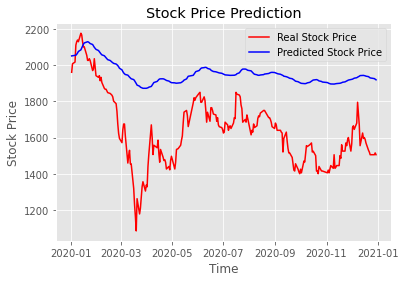

In [16]:
# plot the results 
plt.plot(graph['Adj Close'], color = 'red', label = 'Real Stock Price')
plt.plot(graph['Predict_Value'], color = 'blue', label = 'Predicted Stock Price')
#plt.plot(df['Adj Close'], color = 'black', label = 'Past Stock')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('Stock Price SVR LSTM 1.png')
files.download("Stock Price SVR LSTM 1.png")
plt.show()

In [17]:
final  = test_df.drop(test_df.index[0:36])
final.reset_index(inplace=True)
final.rename(columns = {'index':'Date'})
final = final.drop(columns=['High','Low','Open','Volume','Close'])
final['Predict_Value'] = predicted_y[0]
final['Selisih'] = final['Adj Close'] - final['Predict_Value']
final['Lost/Risk (%)'] = abs((final['Adj Close'] - final['Predict_Value'])/final['Predict_Value']*100)
final = final.drop(columns=['Adj Close'])

In [18]:
percent = test_df.drop(test_df.index[0:35])
percent = percent.drop(test_df.index[-1])
percent.reset_index(inplace=True)
percent.rename(columns = {'index':'Date'}) 
percent = percent.drop(columns=['High','Low','Open','Volume','Close'])
percent['Next Day'] = predicted_y
percent['Plus or Minus']= percent['Adj Close'] - percent['Next Day']
percent['Next Day (%)']= (((percent['Adj Close'] - percent['Next Day'])/percent['Adj Close'])*100)

In [19]:
True_Next_Day = test_df.drop(test_df.index[0:35])
True_Next_Day = True_Next_Day.drop(test_df.index[-1])
True_Next_Day.reset_index(inplace=True)
True_Next_Day.rename(columns = {'index':'Date'}) 
True_Next_Day = True_Next_Day.drop(columns=['High','Low','Open','Volume','Close'])
True_Next_Day['True Next Day'] = org_y
True_Next_Day['True Plus or Minus']= (True_Next_Day['Adj Close'] - True_Next_Day['True Next Day'])
True_Next_Day['True Next Day (%)']= (((True_Next_Day['Adj Close'] - True_Next_Day['True Next Day'])/True_Next_Day['Adj Close'])*100)
True_Next_Day = True_Next_Day.drop(columns=['Adj Close'])

In [20]:
Concating = percent.merge(final, how='outer', on='Date')
Concating = Concating.merge(True_Next_Day, how='outer', on='Date')
#Concating.set_index('Date', inplace=True)
Final_Predict = Concating.copy()
Final_Predict['Harga Saham Hari ini'] = Concating['Adj Close']
Final_Predict['Prediksi Besok'] = Concating['Plus or Minus']
Final_Predict['Harga Besok Sebenarnya'] = Concating['True Plus or Minus']
Final_Predict['Prediksi Besok (%)'] = (Concating['Next Day (%)'])
Final_Predict['Harga Besok Sebenarnya (%)'] = Concating['True Next Day (%)']
Final_Predict['Selisih Prediksi'] = (Final_Predict['Harga Besok Sebenarnya'] - Final_Predict['Prediksi Besok'])
Final_Predict['Harga Sebenarnya'] = Concating['True Next Day']
Final_Predict['Risk/MAPE(%)'] = (np.abs((Final_Predict['Harga Besok Sebenarnya'] - Final_Predict['Prediksi Besok']) / Final_Predict['True Next Day'])) * 100
Final_Predict['Risk/MAPE(%)'] = round(Final_Predict['Risk/MAPE(%)'], 2)
Final_Predict = Final_Predict.drop(columns=['Adj Close', 'Next Day', 'Plus or Minus', 'Next Day (%)',
                                            'Predict_Value', 'Selisih', 'Lost/Risk (%)', 'True Plus or Minus',
                                            'True Next Day (%)','True Next Day'])
Final_Predict = Final_Predict.replace(0, np.nan)
Final_Predict = Final_Predict.dropna()
Final_Predict['Prediksi Uptrend'] = Final_Predict['Prediksi Besok'].apply(lambda x: 1 if x >= 0 else 0)
Final_Predict['Asli Uptrend'] = Final_Predict['Harga Besok Sebenarnya'].apply(lambda x: 1 if x >= 0 else 0)
Final_Predict.set_index('Date', inplace=True)
Final_Predict.shape

(226, 10)

Risk Ekspektasi - Blindly belief

Logika ekpektasi - Saham A saya beli kemarin Rp. 1000, dan prediksi ML LSTM menginfokan hari ini naik 200 menjadi 1200 sehingga saya tergetkan jual 1200. ketika saya jual 1200, ternyata harga penutupannya 1500, naik 500. berarti selisihnya dari prediksi dan harga asli adalah Rp 300 (Rp. 500 - Rp. 200), menandakan risiko ekpektasinya adalah 20% (Rp 300/1500) dari harga saham, sedangkan risiko ekpektasi kenaikan dan penurunannya adalah 60% dari ekpektasi kehilangan peluang (Ekpektasi peluang = (500-200)/500*100)

Risiko Ekpektasi lainnya - 
Saham A saya beli kemarin Rp. 1000 dengan prediksi ML LSTM hari ini 1200, naik 200 sehingga saya tergetkan jual Rp. 1200. ketika saya melihat saham menyentuh 800, saya pikir itu adalah kesempatan beli karena perkiraan penutupan ML LSTM adalah 1200, dengan harapan mendapat keutungan ketika penutupan. Namun, prediksinya salah, dan ternyata penutupannya adalah 800 dan saham saya tidak laku, dan terjadi penurunan 200 dari hari kemarin. Disini saya kehilangan kesempatan cut loss dan justru menumpuk saham ketika seharusnya cutloss. Jika dikalkulasikan -400 dari harapan awal 1200 menjadi 800 (-200-200), menandakan risk ekpektasi dari harga sahamnya 50% (-400/800*100), atau perbedaan ekpektasinya 200% dari peluang cutloss. Risiko dari ketamakan.

In [21]:
Final_Predict.head(10)

,Harga Saham Hari ini,Prediksi Besok,Harga Besok Sebenarnya,Prediksi Besok (%),Harga Besok Sebenarnya (%),Selisih Prediksi,Harga Sebenarnya,Risk/MAPE(%),Prediksi Uptrend,Asli Uptrend
Date,,,,,,,,,,
2019-12-30,1970.319580,-81.032959,9.382446,-4.112681,0.476189,90.415405,1960.937134,4.61,0,1
2020-01-02,1960.937134,-91.091431,-46.912354,-4.645301,-2.392344,44.179077,2007.849487,2.20,0,0
2020-01-03,2007.849487,-45.624146,-9.382568,-2.272289,-0.467294,36.241577,2017.232056,1.80,0,0
2020-01-06,2017.232056,-38.106323,-93.824585,-1.889040,-4.651155,-55.718262,2111.056641,2.64,0,0
2020-01-07,2111.056641,50.740234,-18.765137,2.403547,-0.888898,-69.505371,2129.821777,3.26,1,0
2020-01-08,2129.821777,62.499268,-9.382324,2.934483,-0.440522,-71.881592,2139.204102,3.36,1,0
2020-01-09,2139.204102,63.321777,9.382324,2.960062,0.438589,-53.939453,2129.821777,2.53,1,1
2020-01-10,2129.821777,44.881592,-46.912354,2.107293,-2.202642,-91.793945,2176.734131,4.22,1,0
2020-01-13,2176.734131,80.950195,9.382568,3.718883,0.431039,-71.567627,2167.351562,3.30,1,1


In [22]:
MAPE = np.mean(np.abs((Final_Predict['Harga Besok Sebenarnya'] - Final_Predict['Prediksi Besok']) / Final_Predict['Harga Sebenarnya'])) * 100
print('Mape :', MAPE)

Mape : 20.68700263775639


In [23]:
pred_uptrend = Final_Predict['Prediksi Uptrend']
true_trend = Final_Predict['Asli Uptrend']

# calculate accuracy
from sklearn.metrics import accuracy_score
Accuracy = accuracy_score(true_trend, pred_uptrend)
print('Accuracy :', Accuracy)


# calculate prediction
from sklearn.metrics import precision_score
precision = precision_score(true_trend, pred_uptrend, average='binary')
print('Precision : %.3f' % precision)

# calculate recall
from sklearn.metrics import recall_score
recall = recall_score(true_trend, pred_uptrend, average='binary')
print('Recall : %.3f' % recall)

# calculate score
from sklearn.metrics import f1_score
score = f1_score(true_trend, pred_uptrend, average='binary')
print('F1 Score : %.3f' % score)

#AUC Score
from sklearn.metrics import roc_auc_score 
auc = roc_auc_score(true_trend, pred_uptrend)
print('AUC Score : ', auc)

Accuracy : 0.4336283185840708
Precision : 0.571
Recall : 0.031
F1 Score : 0.059
AUC Score :  0.5000399584432191


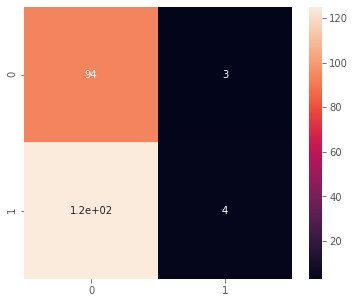

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix(true_trend, pred_uptrend)
plt.figure(figsize = (6, 5))
sns.heatmap(confusion_matrix(true_trend, pred_uptrend), annot = True)

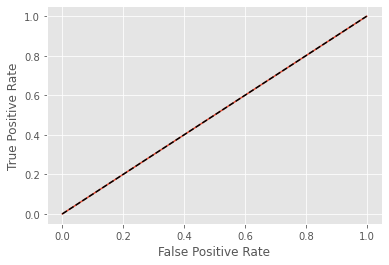

In [25]:
from sklearn.metrics import roc_curve 
fpr, tpr, thresholds = roc_curve(true_trend, pred_uptrend)


import matplotlib.pyplot as plt 
plt.plot(fpr, tpr) 
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate") 
plt.plot([0, 1], [0, 1], "k--") 
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

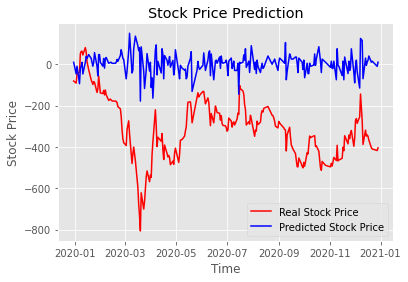

In [26]:
# plot the results 
plt.plot(Final_Predict['Prediksi Besok'], color = 'red', label = 'Real Stock Price')
plt.plot(Final_Predict['Harga Besok Sebenarnya'], color = 'blue', label = 'Predicted Stock Price')
#plt.plot(Final_Predict['Risk/MAPE(%)'], color = 'black', label = 'RISK/MAPE(%)')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('Stock Price SVR LSTM 1.png')
files.download("Stock Price SVR LSTM 1.png")
plt.show()

In [27]:
#### Mencari Data STAT MODEL

In [28]:
a = X_test
a = np.reshape(a, (-1, 36))
a = scaler.inverse_transform(a)
a = pd.DataFrame(a)

In [29]:
b = y_test
#b = np.reshape(b, (-1, 36))
b = scaler.inverse_transform(b)
b = pd.DataFrame(b)

In [30]:
#OLS Model
import statsmodels.api as sm
X = a
Y = b
X = sm.add_constant(X)
model_ols = sm.OLS(Y,X)
results = model_ols.fit()

In [31]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      0   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     120.7
Date:                Tue, 18 May 2021   Prob (F-statistic):          8.12e-119
Time:                        07:09:24   Log-Likelihood:                -1251.4
No. Observations:                 242   AIC:                             2577.
Df Residuals:                     205   BIC:                             2706.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         75.1658     30.974      2.427      0.016      14.098     136.233
0              0.0626      0.073      0.862      0.390      -0.081       0.206
1             -0.2118      0.103     -2.061      0.041      -0.414      -0.009
2              0.0578      0.103      0.563      0.574      -0.144       0.260
3              0.0585      0.102      0.573      0.567      -0.143       0.260
4              0.0403      0.103      0.393      0.695      -0.162       0.243
5             -0.0775      0.103     -0.751      0.454      -0.281       0.126
6              0.0545      0.104      0.526      0.600      -0.150       0.259
7              0.1230      0.103      1.191      0.235      -0.081       0.327
8             -0.1600      0.103     -1.558      0.121      -0.362       0.043
9              0.0199      0.103      0.194      0.847      -0.183       0.222
10             0.0099      0.102      0.097      0.923      -0.192       0.211
11             0.0922      0.102      0.903      0.367      -0.109       0.293
12            -0.1104      0.102     -1.085      0.279      -0.311       0.090
13            -0.0997      0.102     -0.981      0.328      -0.300       0.101
14             0.0782      0.102      0.767      0.444      -0.123       0.279
15            -0.0306      0.102     -0.300      0.765      -0.232       0.170
16             0.2036      0.101      2.021      0.045       0.005       0.402
17            -0.1840      0.101     -1.831      0.069      -0.382       0.014
18             0.1502      0.100      1.496      0.136      -0.048       0.348
19            -0.1755      0.101     -1.738      0.084      -0.375       0.024
20             0.0883      0.101      0.871      0.385      -0.112       0.288
21            -0.0137      0.101     -0.135      0.892      -0.214       0.186
22             0.0459      0.102      0.452      0.652      -0.154       0.246
23             0.0343      0.100      0.344      0.731      -0.162       0.231
24             0.0253      0.100      0.253      0.800      -0.172       0.222
25            -0.0968      0.099     -0.980      0.328      -0.292       0.098
26             0.0639      0.099      0.648      0.517      -0.130       0.258
27            -0.1181      0.098     -1.201      0.231      -0.312       0.076
28            -0.0215      0.099     -0.218      0.828      -0.216       0.173
29             0.0959      0.099      0.971      0.333      -0.099       0.291
30            -0.1567      0.098     -1.594      0.113      -0.351       0.037
31             0.1474      0.098      1.508      0.133      -0.045       0.340
32            -0.1250      0.097     -1.284      0.201      -0.317       0.067
33             0.1867      0.097      1.931      0.055      -0.004       0.377
34            -0.0804      0.097     -0.832      0.406      -0.271       0.110
35